# Microsoft Learn Location Mention Recognition Challenge


## Problem statement
During disasters, timely identification of critical information such as medical needs, shelter requirements, and reports of trapped individuals is essential for effective response. However, the usefulness of microblogging posts, such as those on X (formerly Twitter), is limited when they lack precise geotagging. While exact GPS data is often scarce, many posts include place names or street names (toponyms) that can be valuable for estimating locations. Due to the high volume of such posts, manual extraction of these location cues is impractical. This challenge aims to develop automated systems for Location Mention Recognition (LMR) in microblogging posts, enabling authorities to swiftly locate and respond to critical needs during emergencies.


### Data collection
The data from this challenge was provide by Zindi Africa.

In [1]:
 # Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# loading the data 
train = pd.read_csv('Train_1.csv')
test = pd.read_csv('Test_microsoft.csv')
submission = pd.read_csv('SampleSubmission_microsoft.csv')

In [3]:
print(train.shape,test.shape,submission.shape)

(73072, 3) (2942, 2) (2942, 2)


In [4]:
train.head()

,tweet_id,text,location
0,ID_1001136212718088192,NaN,EllicottCity
1,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland
3,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland
4,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland


In [5]:
test.head()

,tweet_id,text
0,ID_1001154804658286592,What is happening to the infrastructure in New...
1,ID_1001155505459486720,SOLDER MISSING IN FLOOD.. PRAY FOR EDDISON HER...
2,ID_1001155756371136512,RT @TIME: Police searching for missing person ...
3,ID_1001159445194399744,Flash Flood Tears Through Maryland Town For Se...
4,ID_1001164907587538944,Ellicott City #FLOODING Pictures: Maryland Gov...


In [6]:
submission.head()

,tweet_id,location
0,ID_1001154804658286592,NaN
1,ID_1001155505459486720,NaN
2,ID_1001155756371136512,NaN
3,ID_1001159445194399744,NaN
4,ID_1001164907587538944,NaN


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73072 entries, 0 to 73071
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  73072 non-null  object
 1   text      16448 non-null  object
 2   location  43460 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2942 entries, 0 to 2941
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2942 non-null   object
 1   text      2942 non-null   object
dtypes: object(2)
memory usage: 46.1+ KB


The data has alot of missing values.

In [9]:
train.isnull().sum()

tweet_id        0
text        56624
location    29612
dtype: int64

Most of the data in the train data is missing

In [10]:
test.isnull().sum()

tweet_id    0
text        0
dtype: int64

No missing values in the test dataset

In [11]:
train.duplicated().sum()

0

In [12]:
test.duplicated().sum()

0

In [13]:
# dropping the missing value 
train = train.dropna()

In [14]:
train.isnull().sum()

tweet_id    0
text        0
location    0
dtype: int64

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11849 entries, 1 to 73071
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  11849 non-null  object
 1   text      11849 non-null  object
 2   location  11849 non-null  object
dtypes: object(3)
memory usage: 370.3+ KB


In [16]:
train.apply(lambda x:len(x.unique()))

tweet_id    11849
text        11849
location     3448
dtype: int64

In [17]:
train['location'].value_counts()

Mexico                               582
California                           544
Ecuador                              539
Nebraska                             495
Haiti                                424
                                    ... 
Florida Mexico Nebraska Texas          1
Chimanimani- Zimbabwe                  1
Mozambique South African Zimbabwe      1
Manicaland Mutare                      1
Israels Mexico City Thailand           1
Name: location, Length: 3448, dtype: int64

## Text cleaning

In [18]:
import nltk
import string
import re
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
stopword = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
from textblob import TextBlob
from wordcloud import WordCloud
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image

In [19]:
#CONCATENATING BOTH THE TEST AND TRAIN FOR EASY DATA MANIPULATON
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)
data

,tweet_id,text,location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland
...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN


In [20]:
# #storing it into a data frame for easy manipulation
# content = pd.DataFrame(content, columns=['text'])

In [21]:
# Removing Digits
data['cleaned_text'] = data['text'].apply(lambda d: re.sub(r'\d','', d) if isinstance(d, str) else d)
data['cleaned_location'] = data['location'].apply(lambda d: re.sub(r'\d','', d) if isinstance(d, str) else d)


In [22]:
# Removing all commas
data['cleaned_text'] = data['cleaned_text'].apply(lambda v: re.sub(',', '', v) if isinstance(v, str) else v)
data['cleaned_location'] = data['cleaned_location'].apply(lambda v: re.sub(',', '', v) if isinstance(v, str) else v)


In [23]:
#a function to remove emojis
def remove_emoji(text):
    if not isinstance(text, str):
        return text 
    emoji_pattern = re.compile(
        "[" 
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

data['cleaned_text'] = data['cleaned_text'].apply(remove_emoji)
data['cleaned_location'] = data['cleaned_location'].apply(remove_emoji)
data

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,Flash floods struck a Maryland city on Sunday ...,Maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,State of emergency declared for Maryland flood...,Maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,Other parts of Maryland also saw significant d...,Baltimore Maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,Catastrophic Flooding Slams Ellicott City Mary...,Ellicott City Maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,WATCH: missing after flash #FLOODING devastat...,Ellicott City Maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,@PurinaCatChow he wants to donate some food to...,NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,@HannahStocking I live the Mexico earthquake a...,NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN


In [24]:
#remove HTML tags
def remove_html(text):
    if not isinstance(text, str):
        return text
    html_pattern = re.compile(r'<.*?>')
    return html_pattern.sub(r'', text)

data['cleaned_text'] = data['cleaned_text'].apply(remove_html)
data['cleaned_location'] = data['cleaned_location'].apply(remove_html)
data

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,Flash floods struck a Maryland city on Sunday ...,Maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,State of emergency declared for Maryland flood...,Maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,Other parts of Maryland also saw significant d...,Baltimore Maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,Catastrophic Flooding Slams Ellicott City Mary...,Ellicott City Maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,WATCH: missing after flash #FLOODING devastat...,Ellicott City Maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,@PurinaCatChow he wants to donate some food to...,NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,@HannahStocking I live the Mexico earthquake a...,NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN


In [25]:
# remove URLs
def remove_URL(text):
    if not isinstance(text, str):
        return text
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

data['cleaned_text'] = data['cleaned_text'].apply(remove_URL)
data['cleaned_location'] = data['cleaned_location'].apply(remove_URL)
data

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,Flash floods struck a Maryland city on Sunday ...,Maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,State of emergency declared for Maryland flood...,Maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,Other parts of Maryland also saw significant d...,Baltimore Maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,Catastrophic Flooding Slams Ellicott City Mary...,Ellicott City Maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,WATCH: missing after flash #FLOODING devastat...,Ellicott City Maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,@PurinaCatChow he wants to donate some food to...,NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,@HannahStocking I live the Mexico earthquake a...,NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN


## Data Preparation, Tokenization, Stopwords Removal and Stemming

#### lower casing the text

In [26]:
#converting text into lowercase
data['cleaned_text'] = data['cleaned_text'].str.lower()
data['cleaned_location'] = data['cleaned_location'].str.lower()
data

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,flash floods struck a maryland city on sunday ...,maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,state of emergency declared for maryland flood...,maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,other parts of maryland also saw significant d...,baltimore maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,catastrophic flooding slams ellicott city mary...,ellicott city maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,watch: missing after flash #flooding devastat...,ellicott city maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,@purinacatchow he wants to donate some food to...,NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,@hannahstocking i live the mexico earthquake a...,NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,rt @globalcalgary: watch: national taco day in...,NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,oaxaca & chiapas – mexico’s poorest states – h...,NaN


In [27]:
#filter out words that are shorter than or equal to two characters.
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))


In [28]:
 data.sample(10)

,tweet_id,text,location,cleaned_text,cleaned_location
2054,ID_1040550528386834432,Hurricane Florence has knocked out power to mo...,North Carolina,hurricane florence has knocked out power more ...,north carolina
2570,ID_1062051934826246144,"Death toll hits 31, hundreds missing in record...",Cali California,death toll hits hundreds missing record-breaki...,cali california
7678,ID_783488305128144896,You can help provide relief in #Haiti for thos...,Haiti,you can help provide relief #haiti for those a...,haiti
12428,ID_1061150344103653376,At least 9 die in California wildfires as tens...,NaN,least die california wildfires tens thousands ...,NaN
7811,ID_783675792349724672,Hurricane Matthew moves into Bahamas after bat...,Bahamas Haiti,hurricane matthew moves into bahamas after bat...,bahamas haiti
9875,ID_907942430992883712,Just when you thought it was safe.San Diego qu...,San Diego,just when you thought was safe.san diego quake...,san diego
3427,ID_1108352212609232896,Now we have a President who wants to oversee d...,Zimbabweans,now have president who wants oversee distribut...,zimbabweans
14089,ID_877124359478927360,Donation from #Bangladesh to assist the recent...,NaN,donation from #bangladesh assist the recent #f...,NaN
3451,ID_1108432465503367168,Dear World Leaders: Please make sure all donat...,Zimbabwe,dear world leaders: please make sure all donat...,zimbabwe
4686,ID_1116623360148983808,Farmers in some of hardest-hit areas of #Mozam...,Mozambique,farmers some hardest-hit areas #mozambique rec...,mozambique


In [29]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
punctuation = string.punctuation + "’‘"
# Apply the function to remove all punctuation characters, ignoring non-string values
data['cleaned_text'] = data['cleaned_text'].apply(lambda doc: "".join([x for x in doc if x not in punctuation]) if isinstance(doc, str) else doc)
data['cleaned_location'] = data['cleaned_location'].apply(lambda doc: "".join([x for x in doc if x not in punctuation]) if isinstance(doc, str) else doc)
data



,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,flash floods struck maryland city sunday washi...,maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,state emergency declared for maryland flooding...,maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,other parts maryland also saw significant dama...,baltimore maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,catastrophic flooding slams ellicott city mary...,ellicott city maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,watch missing after flash flooding devastates ...,ellicott city maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,purinacatchow wants donate some food homeless ...,NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,hannahstocking live the mexico earthquake and ...,NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,globalcalgary watch national taco day calgary ...,NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,oaxaca chiapas mexicos poorest states harshest...,NaN


#### Removing Stop words

In [31]:
stop_words = set(stopwords.words("english"))
print(stop_words)

{'himself', 'here', 'can', 'who', 'where', 'each', 'hers', 'them', 'y', "needn't", "wouldn't", 'but', 'in', 'once', 'other', 'so', 'a', 'his', 'shouldn', 'should', 'was', 'below', 'under', 'isn', 'over', 'just', 'again', 'has', "she's", 'they', 'about', 'how', 'most', 'd', 'when', 'after', "you've", 'doesn', 'are', 'am', 'be', 'against', 'have', 'these', "that'll", 'such', 'won', 'themselves', 'had', 'needn', 'than', 'out', 'at', "should've", 'ours', "doesn't", 'nor', 'itself', "won't", 'to', 'haven', 'he', 'does', 'any', 'not', 'ma', 'because', 'aren', 'off', 'hasn', 'i', 'herself', 'that', 'me', 'hadn', 'couldn', 'there', 'same', 'ourselves', 'if', "aren't", "couldn't", 'your', 'is', 'were', 'no', "haven't", 'into', 'yours', 'been', 'very', 'she', "it's", "wasn't", 'did', 'while', "weren't", 'being', 'before', 'having', 'why', 'wasn', 'now', 'their', 'm', "hadn't", 'the', 'you', 'then', 'and', 'during', 'doing', 'of', 'will', 'it', 'up', 'from', 'her', 'on', 'what', 'do', 'my', 't', 

In [32]:
data['cleaned_text'] = data['cleaned_text'].apply(lambda y: " ".join([j for j in y.split() if j not in stop_words]))
data

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,flash floods struck maryland city sunday washi...,maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,state emergency declared maryland flooding via...,maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,parts maryland also saw significant damage sun...,baltimore maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,catastrophic flooding slams ellicott city mary...,ellicott city maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,watch missing flash flooding devastates ellico...,ellicott city maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,purinacatchow wants donate food homeless cats ...,NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,hannahstocking live mexico earthquake house da...,NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,globalcalgary watch national taco day calgary ...,NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,oaxaca chiapas mexicos poorest states harshest...,NaN


### Tokenization

In [33]:
data['cleaned_text'] = data['cleaned_text'].apply(word_tokenize)
data.sample(10)

,tweet_id,text,location,cleaned_text,cleaned_location
5733,ID_1176600565914263552,@SalmanSoz @PMOIndia When the siege is lifted ...,Kashmir,"[salmansoz, pmoindia, siege, lifted, kashmir, ...",kashmir
11661,ID_914218787892842496,"Fantastic work, MarcoFabian_10! ὄF The eintrac...",Mexicos,"[fantastic, work, marcofabian, eintrachteng, p...",mexicos
5822,ID_1176848695507243008,Pakistan Army chief General Bajwa visits areas...,Pakistan,"[pakistan, army, chief, general, bajwa, visits...",pakistan
9018,ID_872194467725553664,RT @reliefweb: .@UNmigration to assist #SriLan...,SriLanka,"[reliefweb, unmigration, assist, srilanka, flo...",srilanka
4722,ID_1167494999732346880,"Red Cross deploys TN volunteers to GA, FL to p...",FL GA TN,"[red, cross, deploys, volunteers, prepare, hur...",fl ga tn
4090,ID_1111267612682534912,Infogressive is still donating 25% of their se...,Nebraskas,"[infogressive, still, donating, service, fees,...",nebraskas
9691,ID_906209380235870208,Florida governor Rick Scott warns all resident...,Florida,"[florida, governor, rick, scott, warns, reside...",florida
955,ID_1025921960788860928,"Fire Risk warning Aug 4-5: Attica, Aegean isla...",Aegean islands Attica Greece,"[fire, risk, warning, aug, attica, aegean, isl...",aegean islands attica greece
8596,ID_798030484466855936,ὢB sad #NZeq #NewZealand #earthquake: Two conf...,NewZealand,"[sad, nzeq, newzealand, earthquake, two, confi...",newzealand
2888,ID_1064517751912521728,@DavidKelsey3 @Alyssa_Milano Im willing to bet...,California Georgia,"[davidkelsey, alyssamilano, willing, bet, geor...",california georgia


### Part of speech tags

In [34]:
data['cleaned_text'] = data['cleaned_text'].apply(nltk.tag.pos_tag)
data.head()

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,"[(flash, JJ), (floods, NNS), (struck, VBD), (m...",maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,"[(state, NN), (emergency, NN), (declared, VBD)...",maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,"[(parts, NNS), (maryland, NN), (also, RB), (sa...",baltimore maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,"[(catastrophic, JJ), (flooding, VBG), (slams, ...",ellicott city maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,"[(watch, NN), (missing, VBG), (flash, NN), (fl...",ellicott city maryland


### Convert part of speech to wordnet format

In [35]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

data['cleaned_text'] = data['cleaned_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

data

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,"[(flash, a), (floods, n), (struck, v), (maryla...",maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,"[(state, n), (emergency, n), (declared, v), (m...",maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,"[(parts, n), (maryland, n), (also, r), (saw, v...",baltimore maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,"[(catastrophic, a), (flooding, v), (slams, a),...",ellicott city maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,"[(watch, n), (missing, v), (flash, n), (floodi...",ellicott city maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,"[(purinacatchow, n), (wants, v), (donate, a), ...",NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,"[(hannahstocking, v), (live, a), (mexico, n), ...",NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,"[(globalcalgary, a), (watch, n), (national, a)...",NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,"[(oaxaca, a), (chiapas, n), (mexicos, n), (poo...",NaN


In [36]:
# Applying word lemmatizer(converts the word to a meaningful base form. For example, "running" becomes "run", "better" becomes "good" if part-of-speech is considered.)


wnl = WordNetLemmatizer()

data['cleaned_text'] = data['cleaned_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

data

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,"[flash, flood, strike, maryland, city, sunday,...",maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,"[state, emergency, declare, maryland, flood, v...",maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,"[part, maryland, also, saw, significant, damag...",baltimore maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,"[catastrophic, flood, slams, ellicott, city, m...",ellicott city maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,"[watch, miss, flash, flooding, devastate, elli...",ellicott city maryland
...,...,...,...,...,...
14786,ID_915017703055749120,@PurinaCatChow he wants to donate some food to...,NaN,"[purinacatchow, want, donate, food, homeless, ...",NaN
14787,ID_915026957758328832,@HannahStocking I live the Mexico earthquake a...,NaN,"[hannahstocking, live, mexico, earthquake, hou...",NaN
14788,ID_915253441726889984,RT @GlobalCalgary: WATCH: National Taco Day in...,NaN,"[globalcalgary, watch, national, taco, day, ca...",NaN
14789,ID_915971980859400192,Oaxaca & Chiapas – Mexico’s poorest states – h...,NaN,"[oaxaca, chiapas, mexico, poor, state, harshes...",NaN


### Data Visualization

#### Most common unigrams

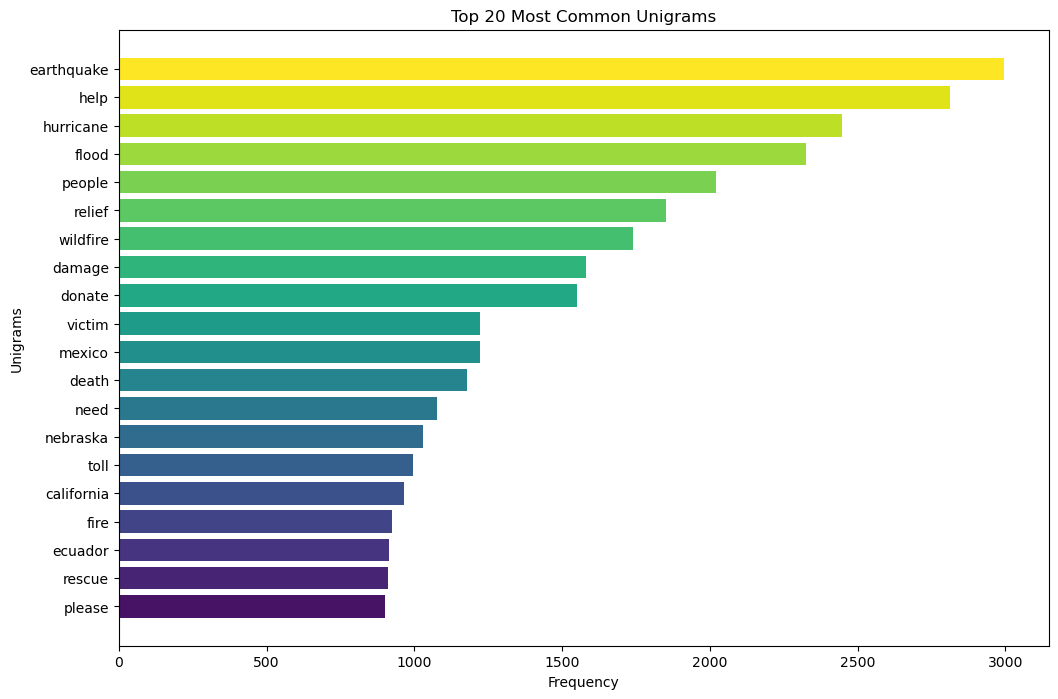

In [37]:
from collections import Counter
import matplotlib.cm as cm

# Flatten the list of words in the entire dataset
all_words = [word for tokens in data['cleaned_text'] for word in tokens]

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the 20 most common unigrams
common_words = word_freq.most_common(20)

# Split the words and their counts for plotting
words, counts = zip(*common_words)

# Define a colormap
colors = cm.viridis_r([i/20 for i in range(20)])

# Plotting the most common unigrams 
plt.figure(figsize=(12, 8))
plt.barh(words, counts, color=colors)
plt.gca().invert_yaxis()
plt.xlabel('Frequency')
plt.ylabel('Unigrams')
plt.title('Top 20 Most Common Unigrams')
plt.show()

#### Most common Bigrams

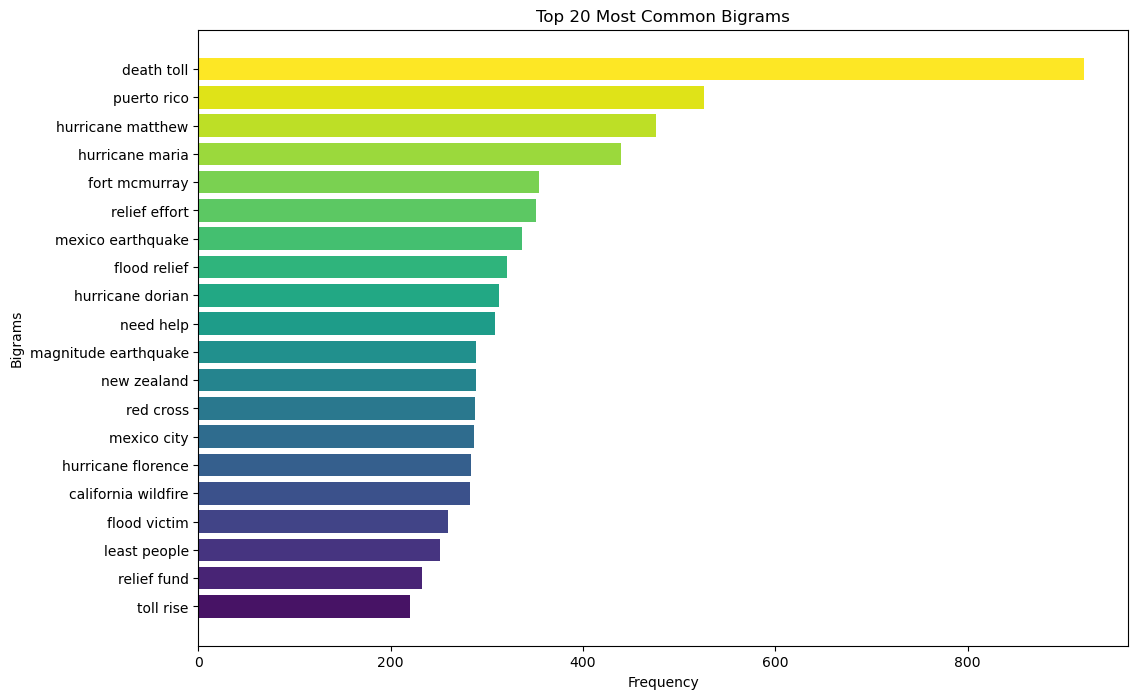

In [38]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nltk import bigrams

# Generate bigrams from the tokenized text
all_bigrams = [bigram for tokens in data['cleaned_text'] for bigram in bigrams(tokens)]

# Count the frequency of each bigram
bigram_freq = Counter(all_bigrams)

# Get the 20 most common bigrams
common_bigrams = bigram_freq.most_common(20)

# Split the bigrams and their counts for plotting
bigrams_labels, counts = zip(*common_bigrams)
bigrams_labels = [' '.join(bigram) for bigram in bigrams_labels]  # Join bigrams into readable format

# Define a colormap
colors = cm.viridis_r([i/20 for i in range(20)])

# Plotting the most common bigrams 
plt.figure(figsize=(12, 8))
plt.barh(bigrams_labels, counts, color=colors)
plt.gca().invert_yaxis()
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 20 Most Common Bigrams')
plt.show()


#### Most common trigrams

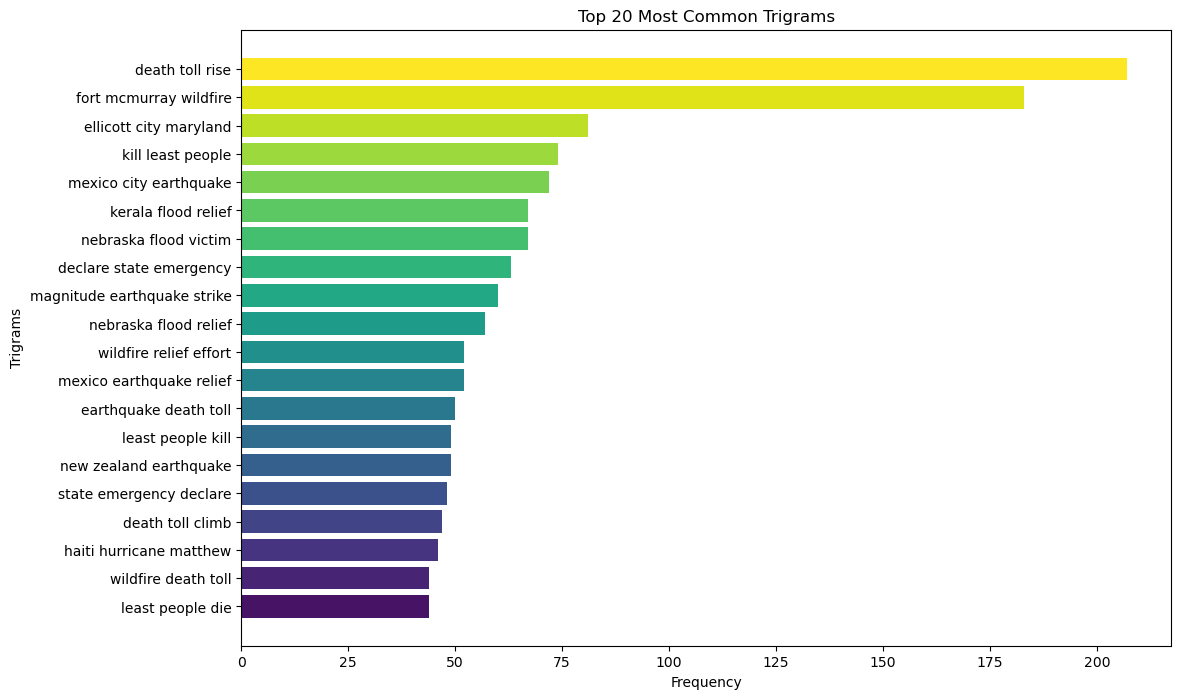

In [39]:
from nltk import trigrams

# Generate trigrams from the tokenized text
all_trigrams = [trigram for tokens in data['cleaned_text'] for trigram in trigrams(tokens)]

# Count the frequency of each trigram
trigram_freq = Counter(all_trigrams)

# Get the 20 most common trigrams
common_trigrams = trigram_freq.most_common(20)

# Split the trigrams and their counts for plotting
trigrams_labels, counts = zip(*common_trigrams)
trigrams_labels = [' '.join(trigram) for trigram in trigrams_labels]  # Join trigrams into readable format

# Define a colormap
colors = cm.viridis_r([i/20 for i in range(20)])

# Plotting the most common trigrams 
plt.figure(figsize=(12, 8))
plt.barh(trigrams_labels, counts, color=colors)
plt.gca().invert_yaxis()
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 20 Most Common Trigrams')
plt.show()


In [40]:
#separating the train and test datasets 
import pandas as pd

# Split the concatenated DataFrame back into 'train' and 'test'
train_split = data.iloc[:ntrain].reset_index(drop=True)
test_split = data.iloc[ntrain:ntrain+ntest].reset_index(drop=True)

# Optionally, you can print the shapes to verify
print(f"Train shape: {train_split.shape}")
print(f"Test shape: {test_split.shape}")




Train shape: (11849, 5)
Test shape: (2942, 5)


In [41]:
train_split.head()

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001136696589631488,"Flash floods struck a Maryland city on Sunday,...",Maryland,"[flash, flood, strike, maryland, city, sunday,...",maryland
1,ID_1001136950345109504,State of emergency declared for Maryland flood...,Maryland,"[state, emergency, declare, maryland, flood, v...",maryland
2,ID_1001137334056833024,Other parts of Maryland also saw significant d...,Baltimore Maryland,"[part, maryland, also, saw, significant, damag...",baltimore maryland
3,ID_1001138374923579392,"Catastrophic Flooding Slams Ellicott City, Mar...",Ellicott City Maryland,"[catastrophic, flood, slams, ellicott, city, m...",ellicott city maryland
4,ID_1001138377717157888,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland,"[watch, miss, flash, flooding, devastate, elli...",ellicott city maryland


In [42]:
test_split.head()

,tweet_id,text,location,cleaned_text,cleaned_location
0,ID_1001154804658286592,What is happening to the infrastructure in New...,NaN,"[happen, infrastructure, new, england, isnt, g...",NaN
1,ID_1001155505459486720,SOLDER MISSING IN FLOOD.. PRAY FOR EDDISON HER...,NaN,"[solder, miss, flood, pray, eddison, hermond, ...",NaN
2,ID_1001155756371136512,RT @TIME: Police searching for missing person ...,NaN,"[time, police, search, miss, person, devastate...",NaN
3,ID_1001159445194399744,Flash Flood Tears Through Maryland Town For Se...,NaN,"[flash, flood, tear, maryland, town, second, t...",NaN
4,ID_1001164907587538944,Ellicott City #FLOODING Pictures: Maryland Gov...,NaN,"[ellicott, city, flooding, picture, maryland, ...",NaN


In [43]:
train_split.to_csv('cleaned_train',index=False)

In [44]:
test_split.to_csv('cleaned_test',index=False)